In [1]:
import cv2,os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.models import load_model
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


# Data Preprocessing

In [2]:
data_path='dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


In [3]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 100*100, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to 

In [4]:
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

np.save('data',data)
np.save('target',new_target)

In [5]:
data=np.load('data.npy')
target=np.load('target.npy')

# Data Training


In [6]:
#CNN

model=Sequential()

#The first CNN layer

#Convolution layer of a kernel size 200
model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
#Relu layer
model.add(Activation('relu'))
#MaxPooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

#The second convolution layer

#Convolution layer of a kernel size 100
model.add(Conv2D(100,(3,3)))
#Relu layer
model.add(Activation('relu'))
#MaxPooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

#Flatten layer to stack the output convolutions from second convolution layer
model.add(Flatten())

#Performing Dropout to avoid overfitting
model.add(Dropout(0.5))

#Dense layer of 64 neurons
model.add(Dense(50,activation='relu'))

#The Final layer with two outputs for two categories
model.add(Dense(2,activation='softmax'))

#Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])



In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 200)       2000      
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 200)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 200)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 100)       180100    
_________________________________________________________________
activation_2 (Activation)    (None, 47, 47, 100)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 100)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 52900)            

In [8]:
#Split data to train and test set (80:20)
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.2)

In [10]:
#Training
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)

Train on 2413 samples, validate on 604 samples
Epoch 1/20
2413/2413 [==============================] - 113s 47ms/step - loss: 0.5939 - accuracy: 0.6855 - val_loss: 0.4253 - val_accuracy: 0.8129
Epoch 2/20
2413/2413 [==============================] - 108s 45ms/step - loss: 0.4304 - accuracy: 0.7973 - val_loss: 0.3772 - val_accuracy: 0.8444
Epoch 3/20
2413/2413 [==============================] - 108s 45ms/step - loss: 0.3418 - accuracy: 0.8421 - val_loss: 0.3164 - val_accuracy: 0.8576
Epoch 4/20
2413/2413 [==============================] - 114s 47ms/step - loss: 0.2633 - accuracy: 0.8902 - val_loss: 0.2848 - val_accuracy: 0.8874
Epoch 5/20
2413/2413 [==============================] - 107s 44ms/step - loss: 0.2248 - accuracy: 0.9105 - val_loss: 0.2726 - val_accuracy: 0.8874
Epoch 6/20
2413/2413 [==============================] - 108s 45ms/step - loss: 0.1879 - accuracy: 0.9200 - val_loss: 0.2812 - val_accuracy: 0.8957
Epoch 7/20
2413/2413 [==============================] - 107s 44ms/step 

In [11]:
model.save('my_model.h5')

In [12]:
#Load the saved model and predict the accuracy

model1 = load_model('my_model.h5')
model1.summary()
results = model1.evaluate(test_data,test_target)
print("Accuracy of the Model %.2f%%" % ( results[1]*100))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 200)       2000      
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 200)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 200)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 100)       180100    
_________________________________________________________________
activation_2 (Activation)    (None, 47, 47, 100)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 100)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 52900)            

In [13]:
# Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
#Predict Y values
y_predicted = model1.predict(test_data)

# get the max values in y_test and put into a list
y_test = [np.argmax(j) for j in test_target]

# get the max values in y_pred and put into a list    
y_pred = [np.argmax(i) for i in y_predicted]

Confusion matrix
[[358  21]
 [ 39 337]]


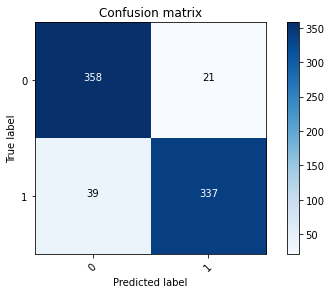

In [15]:
#Plot the confusion matrix
# 0 for without mask, 1 for with mask
names = ["0", "1"]
cm = confusion_matrix(y_test, y_pred,labels=[0,1])
plt.figure()
plot_confusion_matrix(cm, classes=names, title='Confusion matrix')

In [16]:
#Print Classification report and plot the learning curves (training and validation accuracy and loss) of the model

def evaluate(train_data,train_target,test_data,test_target):
  score = model1.evaluate(train_data, train_target, verbose=0) # get training accuracy using training data
  print("Training Accuracy: ", score[1])
  score = model1.evaluate(test_data, test_target, verbose=0) # get testing accuracy using testing data
  print("Testing Accuracy: ", score[1])

def model_eval():
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
  ax1.plot(history.history['accuracy'], label='accuracy')
  ax1.plot(history.history['val_accuracy'], label='val_accuracy')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy')
  ax1.legend()
  ax2.plot(history.history['loss'], label='loss')
  ax2.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy')
  ax2.legend()
  print(evaluate(train_data,train_target,test_data,test_target))
  print(classification_report(y_test,y_pred))  

Training Accuracy:  0.9844216108322144
Testing Accuracy:  0.9205297827720642
None
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       379
           1       0.94      0.90      0.92       376

    accuracy                           0.92       755
   macro avg       0.92      0.92      0.92       755
weighted avg       0.92      0.92      0.92       755



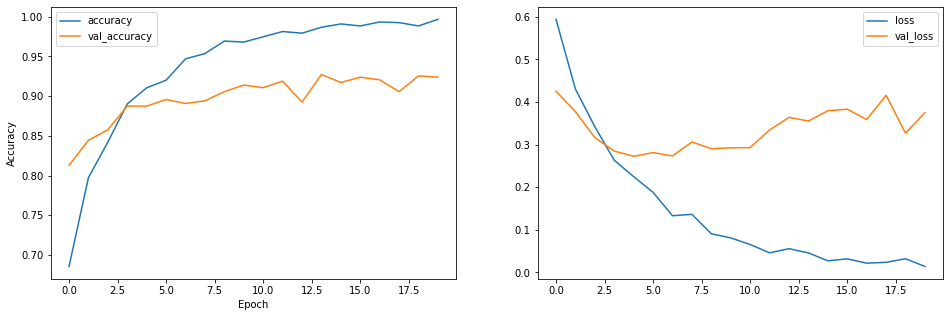

In [17]:
model_eval()

# Detecting face mask in real-time 

In [19]:
#Using openCV

model = load_model('my_model.h5')

face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

source=cv2.VideoCapture(0)
width=int(source.get(cv2.CAP_PROP_FRAME_WIDTH))
height=int(source.get(cv2.CAP_PROP_FRAME_HEIGHT))

writer=cv2.VideoWriter("outputfile.mp4",cv2.VideoWriter_fourcc(*'DIVX'),20,(width,height))



labels_dict={1:'MASK',0:'NO MASK'}
color_dict={0:(0,0,255),1:(0,255,0)}

while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('Face Mask Detector',img)
    writer.write(img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
source.release()
writer.release()       
cv2.destroyAllWindows()